In [1]:
import pandas as pd
import os

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt




In [8]:
# 1. Load the dataset (using a small sample or chunks if needed)
data = pd.read_csv('../data/data.csv', parse_dates=['Date'], index_col='Date')

C:\Users\HP\AppData\Local\Temp\ipykernel_5148\830164793.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/data.csv', parse_dates=['Date'], index_col='Date')


In [9]:
# 2. Sort by date (in case it's not sorted)
data.sort_index(inplace=True)

In [10]:

# 3. Isolate the sales data
sales_data = data['Sales'].values.reshape(-1, 1)



In [11]:
# 4. Scale the sales data to range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(sales_data)

In [12]:
# 5. Create sliding window sequences for LSTM
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(data[i + window_size])
    return np.array(sequences), np.array(labels)

window_size = 60  # Use the last 60 days to predict the next
X, y = create_sequences(scaled_sales, window_size)


In [13]:
# Reshape X to be compatible with LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [14]:
# 6. Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))  # First LSTM layer
model.add(LSTM(50))  # Second LSTM layer
model.add(Dense(1))  # Output layer predicting the next sale
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 7. Train the model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1281s 50ms/step - loss: 0.0168 - val_loss: 0.0158
Epoch 2/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1268s 50ms/step - loss: 0.0156 - val_loss: 0.0153
Epoch 3/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1266s 50ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 4/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1310s 51ms/step - loss: 0.0145 - val_loss: 0.0136
Epoch 5/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 2712s 107ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 6/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1263s 50ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 7/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1299s 51ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 8/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1323s 52ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 9/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1258s 49ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 10/10
25429/25429 ━━━━━━━━━━━━━━━━━━━━ 1240s 49ms/step - loss: 0.0092 - val_loss: 0.0092


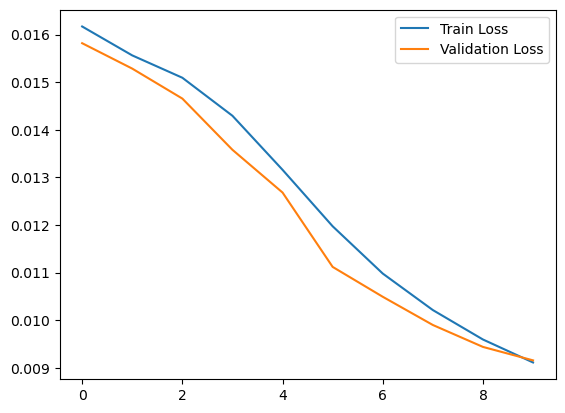

In [16]:
# 8. Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [17]:
# 9. Use the model for prediction
#  predict the next sales value after the last available sequence
last_sequence = scaled_sales[-window_size:].reshape(1, window_size, 1)
predicted_sale = model.predict(last_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


In [18]:
# Inverse transform the prediction back to original scale
predicted_sale = scaler.inverse_transform(predicted_sale)
print(f"Predicted next sale: {predicted_sale[0][0]}")

Predicted next sale: 8047.779296875
